## Neural Style Transfer

### Implementation of https://arxiv.org/abs/1508.06576

In [288]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import statistics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare the images

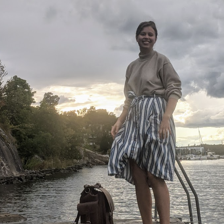

In [289]:
from PIL import Image
import PIL

size = 224,224

content_img = Image.open("./saga.png")
content_img = content_img.resize(size).convert('RGB')
content_img

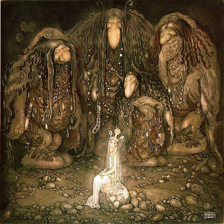

In [290]:
style_img = Image.open("./bauer2.jpg")
style_img = style_img.resize(size)

style_img

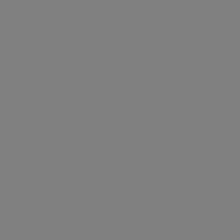

In [291]:
generated_img = Image.new('RGB', size, color = 'gray')
generated_img = generated_img.resize(size)

generated_img

# Setup neural net

In [292]:
class NeuralStyleTransferModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        vgg = models.vgg16(pretrained=pretrained)
        features = nn.ModuleList(vgg.children())[:-1]
        self.model = nn.Sequential(*features)
        self.feature_maps = [] # list (layers) of list (feature maps)
        self.iter_count = 0
        
        for m in self.get_modules():
            for p in m.parameters():
                p.requires_grad = False
        
    def get_modules(self):
        return [module for module in self.model.modules() if type(module) != nn.Sequential and type(module) != NeuralStyleTransferModel]
           
    def forward(self, x):
        self.feature_maps = []
        for i,module in enumerate(self.get_modules()):
            x = module(x)
            if isinstance(module, nn.Conv2d):
                self.feature_maps.append(x.squeeze())
        return self.feature_maps

In [293]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NeuralStyleTransferModel().to(device)

# Preprocessing

In [294]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), regular ImageNet normalization doesn't yield as good result
])

style_batch = preprocess(style_img).unsqueeze(0).to(device)
content_batch = preprocess(content_img).unsqueeze(0).to(device)
generated_batch = preprocess(generated_img).unsqueeze(0).to(device)
generated_batch.requires_grad = True

def reset():
    style_batch = preprocess(style_img).unsqueeze(0).to(device)
    content_batch = preprocess(content_img).unsqueeze(0).to(device)
    generated_batch = preprocess(generated_img).unsqueeze(0).to(device)
    generated_batch.requires_grad = True

# Training

In [295]:
def content_loss(feature_maps_generated, feature_maps_content):
    loss_per_layer = [(g-c).pow(2).sum() / 2 for g,c in zip(feature_maps_generated, feature_maps_content)]
    return torch.sum(torch.stack(loss_per_layer))

In [296]:
def style_loss(feature_maps_generated, feature_maps_style, n_style_maps):
    def _gram_matrix(input):
        num_feature_maps, height, width = input.size()
        features = input.view(1 * num_feature_maps, height * width) # batch size of 1
        G = torch.mm(features, features.t())  # compute the gram matrix

        # Normalize values in gram matrix
        return G.div(1 * num_feature_maps * height * width)
    
    loss_per_layer = []
    
    for i, (fg, fs) in enumerate(zip(feature_maps_generated, feature_maps_style)): # C x H x W
        N = [*fg.shape][0] # number of distinct filters
        M = [*fg.shape][1] # filter size
        G = _gram_matrix(fg) # Gram matrix for generated feature maps
        A = _gram_matrix(fs) # Gram matrix for style feature maps
        layer_loss = 1 / 4 * N**2 * M**2 * ((G-A).pow(2).sum())
        w = 1/n_style_maps if i < n_style_maps else 0
        loss_per_layer.append(w*layer_loss)
    
    return torch.sum(torch.stack(loss_per_layer))

In [297]:
import torch.optim as optim

def fit(n_epochs, learning_rate, alpha, beta, n_style_maps, check_interval=1000):
    reset()

    best_losses = []
    optimizer = optim.Adam([generated_batch], lr=learning_rate)
    
    for epoch in range(n_epochs):    
        # zero gradients
        optimizer.zero_grad()

        # feedforward
        feature_maps_style = model(style_batch)
        feature_maps_content = model(content_batch)
        feature_maps_generated = model(generated_batch)

        assert len(feature_maps_style) == len(feature_maps_content) == len(feature_maps_generated)

        # calculate loss
        loss_content = content_loss(feature_maps_generated, feature_maps_content)
        loss_style = style_loss(feature_maps_generated, feature_maps_style, n_style_maps) 
        total_loss = alpha * loss_content + beta * loss_style

        if epoch % check_interval == 0:
            print(f"In epoch {epoch}, total loss {total_loss}")
            print(f"Content loss: {loss_content.sum()}")
            print(f"Style loss: {loss_style.sum()}")
            
            # if no improvement over 1000 epochs, break early
            best_losses.append(total_loss)
            if len(best_losses) > 1:
                if (best_losses[-1] > best_losses[-2]):
                    print(f"Breaking early, no loss improvement over last {check_interval} epochs")
                    break

        # backpropagate loss
        total_loss.backward()
        with torch.no_grad():
            optimizer.step()
            
    plt.imshow(generated_batch.squeeze().permute(1,2,0).detach().cpu())

The paper use an alpha/beta ratio of 1e-3 & n_style_maps=5. They don't specify number of epochs or learning rate.

In epoch 0, total loss 10959467.0
Content loss: 5662813.5
Style loss: 10902839.0
In epoch 1000, total loss 125948.5390625
Content loss: 7982347.0
Style loss: 46125.0703125
In epoch 2000, total loss 87362.90625
Content loss: 6417064.0
Style loss: 23192.271484375
In epoch 3000, total loss 65018.9453125
Content loss: 5092521.0
Style loss: 14093.736328125
In epoch 4000, total loss 51725.1484375
Content loss: 4210334.0
Style loss: 9621.80859375
In epoch 5000, total loss 44059.171875
Content loss: 3624808.0
Style loss: 7811.09521484375
In epoch 6000, total loss 39254.2109375
Content loss: 3226765.5
Style loss: 6986.5556640625
In epoch 7000, total loss 36064.5078125
Content loss: 2958417.5
Style loss: 6480.3330078125
In epoch 8000, total loss 33750.984375
Content loss: 2760006.0
Style loss: 6150.923828125
In epoch 9000, total loss 32243.12890625
Content loss: 2637691.0
Style loss: 5866.21923828125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


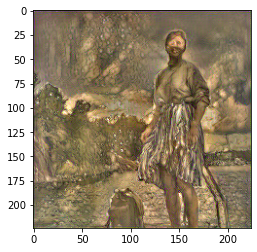

In [298]:
fit(n_epochs=10000, learning_rate=1e-3, alpha=1e-2, beta=1, n_style_maps=5)

In epoch 0, total loss 133829.578125
Content loss: 2562271.25
Style loss: 5716.009765625
In epoch 1000, total loss 106590.765625
Content loss: 1730994.875
Style loss: 20041.02734375
In epoch 2000, total loss 103676.328125
Content loss: 1671979.75
Style loss: 20077.33984375
In epoch 3000, total loss 102531.1875
Content loss: 1648840.75
Style loss: 20089.150390625
In epoch 4000, total loss 101888.390625
Content loss: 1639755.75
Style loss: 19900.6015625
In epoch 5000, total loss 101467.671875
Content loss: 1631813.25
Style loss: 19877.0078125
In epoch 6000, total loss 101130.5625
Content loss: 1627139.25
Style loss: 19773.599609375
In epoch 7000, total loss 100868.40625
Content loss: 1622293.25
Style loss: 19753.740234375
In epoch 8000, total loss 100677.671875
Content loss: 1618067.5
Style loss: 19774.30078125
In epoch 9000, total loss 100459.7421875
Content loss: 1616967.25
Style loss: 19611.376953125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


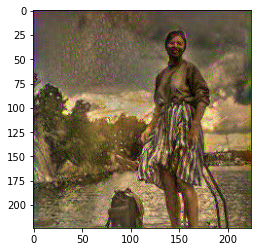

In [299]:
fit(n_epochs=10000, learning_rate=1e-3, alpha=5e-2, beta=1, n_style_maps=5)

In epoch 0, total loss 21134.142578125
Content loss: 1615844.25
Style loss: 19518.298828125
In epoch 1000, total loss 5253.6376953125
Content loss: 3233016.0
Style loss: 2020.621826171875
In epoch 2000, total loss 4879.75146484375
Content loss: 3266396.5
Style loss: 1613.3548583984375
In epoch 3000, total loss 4730.85009765625
Content loss: 3272193.5
Style loss: 1458.656494140625
In epoch 4000, total loss 4622.77001953125
Content loss: 3274763.25
Style loss: 1348.006591796875
In epoch 5000, total loss 4579.0263671875
Content loss: 3273482.0
Style loss: 1305.5439453125
In epoch 6000, total loss 4515.87890625
Content loss: 3271846.25
Style loss: 1244.0322265625
In epoch 7000, total loss 4491.78662109375
Content loss: 3274020.25
Style loss: 1217.76611328125
In epoch 8000, total loss 4435.82080078125
Content loss: 3270534.25
Style loss: 1165.2864990234375
In epoch 9000, total loss 4428.54638671875
Content loss: 3271620.75
Style loss: 1156.9254150390625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


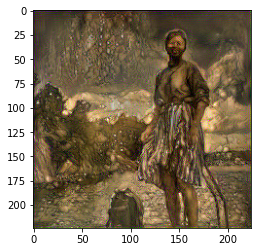

In [300]:
fit(n_epochs=10000, learning_rate=1e-3, alpha=1e-3, beta=1, n_style_maps=5)

In epoch 0, total loss 3502.31787109375
Content loss: 3267126.5
Style loss: 235.1912841796875
In epoch 1000, total loss 1257.7935791015625
Content loss: 1117726.75
Style loss: 140.06680297851562
In epoch 2000, total loss 1195.285400390625
Content loss: 1069967.125
Style loss: 125.31822204589844
In epoch 3000, total loss 1173.7572021484375
Content loss: 1051307.0
Style loss: 122.45023345947266
In epoch 4000, total loss 1159.27880859375
Content loss: 1040450.375
Style loss: 118.828369140625
In epoch 5000, total loss 1150.270751953125
Content loss: 1032872.5
Style loss: 117.39815521240234
In epoch 6000, total loss 1145.0162353515625
Content loss: 1027863.125
Style loss: 117.15308380126953
In epoch 7000, total loss 1139.2279052734375
Content loss: 1023779.0625
Style loss: 115.44873809814453
In epoch 8000, total loss 1136.3426513671875
Content loss: 1020509.9375
Style loss: 115.83267211914062
In epoch 9000, total loss 1133.314697265625
Content loss: 1018392.625
Style loss: 114.9219818115234

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


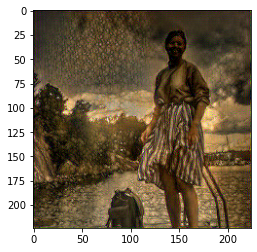

In [301]:
fit(n_epochs=10000, learning_rate=1e-3, alpha=1e-3, beta=1, n_style_maps=3)

In epoch 0, total loss 2089465.25
Content loss: 1016123.0
Style loss: 2088449.125
In epoch 1000, total loss 18324.552734375
Content loss: 4579811.0
Style loss: 13744.7421875
In epoch 2000, total loss 13675.7626953125
Content loss: 4850588.5
Style loss: 8825.173828125
In epoch 3000, total loss 11855.154296875
Content loss: 4967559.0
Style loss: 6887.59521484375
In epoch 4000, total loss 10867.2412109375
Content loss: 5026906.0
Style loss: 5840.3349609375
In epoch 5000, total loss 10320.11328125
Content loss: 5056058.0
Style loss: 5264.05517578125
In epoch 6000, total loss 9983.9453125
Content loss: 5078994.5
Style loss: 4904.951171875
In epoch 7000, total loss 9736.998046875
Content loss: 5085583.0
Style loss: 4651.41552734375
In epoch 8000, total loss 9510.87890625
Content loss: 5097878.0
Style loss: 4413.0009765625
In epoch 9000, total loss 9391.4453125
Content loss: 5101193.5
Style loss: 4290.25146484375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


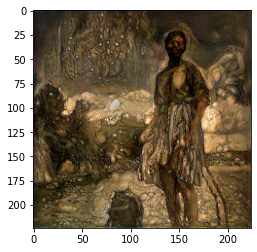

In [302]:
fit(n_epochs=10000, learning_rate=1e-3, alpha=1e-3, beta=1, n_style_maps=6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


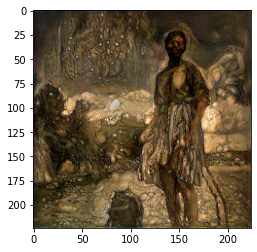

In [303]:
plt.imshow(generated_batch.squeeze().permute(1,2,0).detach().cpu())

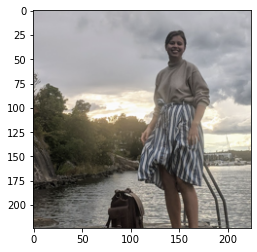

In [304]:
plt.imshow(content_batch.squeeze().permute(1,2,0).detach().cpu())

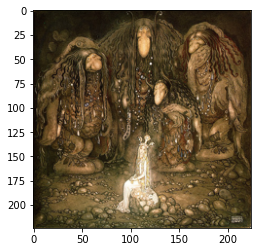

In [305]:
plt.imshow(style_batch.squeeze().permute(1,2,0).detach().cpu())